In [1]:
import paddle.fluid as fluid
import paddle, os 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
BUF_SIZE = 500
BATCH_SIZE = 20

train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(),
    buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE
)

test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
    buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE
)


[==================================================]


In [3]:
train_data = paddle.dataset.uci_housing.train();
sampledata = next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


In [4]:
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
y = fluid.layers.data(name='y', shape=[1], dtype='float32')

y_predict = fluid.layers.fc(input=x, size=1, act=None)

In [5]:
cost = fluid.layers.square_error_cost(input=y_predict,label=y)
avg_cost = fluid.layers.mean(cost)

In [6]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)

In [7]:
test_program = fluid.default_main_program().clone(for_test=True)

In [8]:
use_cuda =False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

In [9]:
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])

In [10]:
iter = 0
iters = []
train_costs = []

def draw_train_process(iter, train_costs):
    title = 'training cost'
    plt.title(title, fontsize = 24)
    plt.xlabel('iter', fontsize = 14)
    plt.ylabel('cost', fontsize = 14)
    plt.plot(iters, train_costs, color = 'red', label = 'training cost')
    plt.grid()
    plt.show()

Pass:0, Cost:50.17821
Test:0, Cost:13.19664
Pass:1, Cost:27.82631
Test:1, Cost:20.66516
Pass:2, Cost:38.52075
Test:2, Cost:1.83925
Pass:3, Cost:60.25095
Test:3, Cost:73.26202
Pass:4, Cost:36.94734
Test:4, Cost:20.11653
Pass:5, Cost:22.37646
Test:5, Cost:4.21397
Pass:6, Cost:29.20440
Test:6, Cost:12.09706
Pass:7, Cost:37.81208
Test:7, Cost:6.49029
Pass:8, Cost:72.02035
Test:8, Cost:8.36119
Pass:9, Cost:54.55923
Test:9, Cost:23.34833
Pass:10, Cost:51.41012
Test:10, Cost:1.61194
Pass:11, Cost:20.13306
Test:11, Cost:4.02177
Pass:12, Cost:89.37009
Test:12, Cost:2.67884
Pass:13, Cost:65.45196
Test:13, Cost:4.31685
Pass:14, Cost:22.29996
Test:14, Cost:19.25218
Pass:15, Cost:43.31995
Test:15, Cost:7.09754
Pass:16, Cost:24.62025
Test:16, Cost:3.46165
Pass:17, Cost:52.76331
Test:17, Cost:7.42932
Pass:18, Cost:75.89264
Test:18, Cost:30.26339
Pass:19, Cost:21.41624
Test:19, Cost:4.34779
Pass:20, Cost:71.14145
Test:20, Cost:9.82052
Pass:21, Cost:29.68860
Test:21, Cost:15.44520
Pass:22, Cost:78.7367

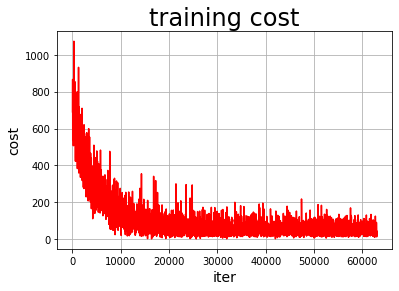

In [28]:
%matplotlib inline
EPOCH_NUM=50
model_save_dir = '/Users/meininghang/fit_a_line.inference.model'

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)
       

In [29]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

In [30]:
infer_results = []
groud_truths = []

def draw_infer_result(groud_truths, infer_results):
    title = 'Boston'
    plt.title(title, fontsize = 24)
    x = np.arange(1, 20)
    y = x
    plt.plot(x,y)
    plt.xlabel('groud truth', fontsize = 14)
    plt.ylabel('infer result', fontsize = 14)
    plt.scatter(groud_truths, infer_results, color = 'green', label = 'traing cost')
    plt.grid()
    plt.show()

infer results: (House Price)
0: 13.55
1: 13.91
2: 13.23
3: 16.28
4: 14.34
5: 15.80
6: 14.96
7: 14.82
8: 10.84
9: 14.08
10: 9.84
11: 13.05
12: 14.13
13: 12.86
14: 12.97
15: 14.87
16: 16.33
17: 16.01
18: 16.19
19: 14.17
20: 14.94
21: 13.30
22: 15.65
23: 15.09
24: 14.82
25: 14.11
26: 15.64
27: 15.59
28: 16.85
29: 15.59
30: 15.29
31: 14.45
32: 14.73
33: 12.96
34: 12.10
35: 14.80
36: 14.89
37: 15.91
38: 16.24
39: 16.03
40: 14.13
41: 13.92
42: 15.91
43: 16.25
44: 16.02
45: 15.72
46: 15.19
47: 16.41
48: 16.39
49: 17.26
50: 14.92
51: 15.22
52: 14.39
53: 14.71
54: 16.19
55: 16.73
56: 16.40
57: 16.97
58: 17.08
59: 17.70
60: 17.58
61: 17.16
62: 14.94
63: 15.65
64: 16.47
65: 17.21
66: 17.02
67: 17.63
68: 17.74
69: 18.60
70: 15.62
71: 15.19
72: 16.68
73: 14.24
74: 16.30
75: 17.21
76: 18.41
77: 19.14
78: 19.50
79: 18.47
80: 17.86
81: 18.55
82: 17.18
83: 18.03
84: 17.05
85: 15.81
86: 14.54
87: 17.41
88: 18.43
89: 22.46
90: 22.63
91: 22.00
92: 20.41
93: 21.89
94: 22.40
95: 21.50
96: 21.92
97: 23.54
98

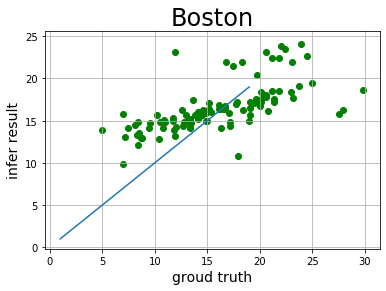

In [31]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)

# 第一次用 paddlepaddle(飞桨)

- 怎么说呢,只能说和 tensor 比起来很奇怪的感觉,参数太多,流程太复杂
- TF 现在已经很接近 numpy 的运行模式,比较简易,而飞桨看起来依然像上个时代的产物
- 坚持七天,混张证书算了.